In [4]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from torch import nn
import torch
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import torch.nn as nn
import os
import glob
from collections import defaultdict

In [5]:
class Kyrgyz(nn.Module):
    def __init__(self):
        super(Kyrgyz, self).__init__()
        self.features = nn.Sequential(
            # conv1 : 3 * 128 * 128
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # conv2 : 16 * 63 * 63
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # conv3 : 32 * 30 * 30
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Flatten : 64 * 14 * 14
        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*14*14, out_features=2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=2048, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=512, out_features=36)  # 36 classes for Kyrgyz letters
        )
    
    def forward(self,x):
        x = self.features(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits
   

In [6]:

# Define the Kyrgyz model class
# Define device configuration (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [7]:
# Load the model
model = Kyrgyz()
model.load_state_dict(torch.load("../results/final_model.pth", map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode


/var/folders/j1/xbp2l_wj5js1yyt_p88w28r00000gn/T/ipykernel_79605/4153567641.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../results/

Kyrgyz(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=36, bias=True)
  )
)

In [8]:

# Define transformations for input image
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),  # Resize the image to 128x128 pixels
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(
            mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
        ),  # Normalize pixel values to [-1, 1]
    ]
)


In [9]:
def recognize_letter(image):
    """
    Recognize the letter in the given image.
    Args:
        image (PIL.Image or np.ndarray): Input image.
    Returns:
        str: Predicted letter.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image).convert('L')  # Convert to grayscale to match model input
    
    # Apply transformations
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Predict the label
    with torch.no_grad():
        output = model(image)
        predicted_idx = output.argmax(1).item()
    
    # Mapping predicted index to the corresponding label
    classes = [
        'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'Ң', 'Ү', 'Ө', 'Ё'
    ]
    
    predicted_label = classes[predicted_idx]
    return predicted_label

In [10]:
def recognize_word(image_path):
    """
    Recognize the word in the given image by splitting it into individual letters.
    Args:
        image_path (str): Path to the input image.
    Returns:
        str: Predicted word.
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image to get a binary representation
    _, binary = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Use morphological operations to close gaps between letter parts
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Find contours of the letters
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    predicted_word = ""
    letter_images = []

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Filter small or large contours to avoid noise and non-letter elements
        if 15 < w < 100 and 15 < h < 100:  # Adjust these values based on your data
            # Extract the letter from the image and add padding
            letter_image = gray[y:y+h, x:x+w]
            letter_image = cv2.copyMakeBorder(letter_image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=255)
            
            # Resize to ensure consistency for the recognizer
            letter_image = cv2.resize(letter_image, (28, 28))  # Adjust size as needed by your model

            # Convert to RGB and then to PIL format
            letter_image = cv2.cvtColor(letter_image, cv2.COLOR_GRAY2RGB)
            letter_image = Image.fromarray(letter_image)

            # Recognize the letter
            predicted_letter = recognize_letter(letter_image)
            predicted_word += predicted_letter
            letter_images.append((letter_image, predicted_letter))

            # Visualize the recognized letter with bounding box and label
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, predicted_letter, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the split letters with their predicted labels
    for idx, (letter_image, predicted_letter) in enumerate(letter_images):
        plt.figure(figsize=(3, 3))
        plt.imshow(letter_image, cmap='gray')
        plt.axis('off')
        plt.title(f'Recognized Letter {idx}: {predicted_letter}')
        plt.show()

    # Display the combined image with predicted letters
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Recognized Word: {predicted_word}')
    plt.show()

    return predicted_word

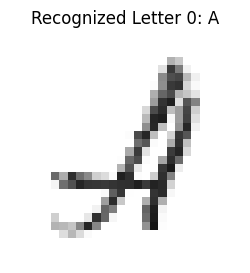

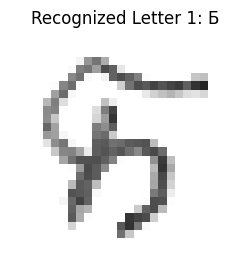

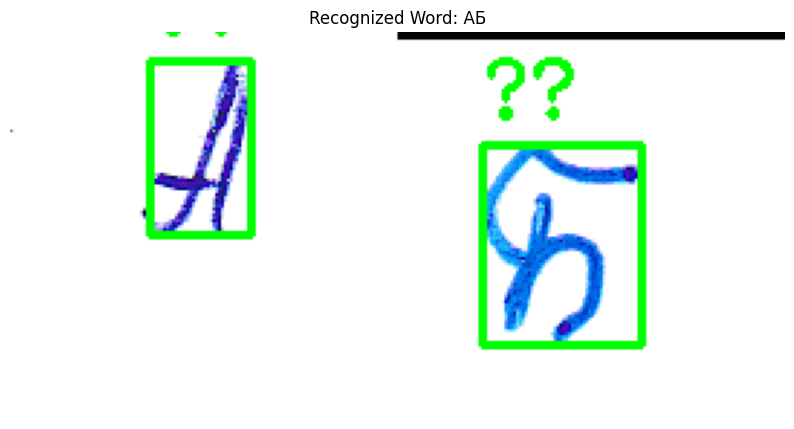

Predicted Word: АБ


In [11]:
# Test the function
image_path = "../data/raw/cyrilic_words/combined_word.png"  # Replace with the path to your jpg image
predicted_word = recognize_word(image_path)
print(f"Predicted Word: {predicted_word}")

In [12]:
def combine_letter_images(image_paths, output_path='combined_word.png'):
    """
    Combine multiple letter images into one image to form a word.
    Args:
        image_paths (list of str): List of paths to the input images (PNG files).
        output_path (str): Path where the combined image will be saved.
    Returns:
        None
    """
    # Load all images
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]

    # Calculate total width and max height for the new image
    total_width = sum(image.width for image in images)
    max_height = max(image.height for image in images)

    # Create a new blank image with a transparent background
    combined_image = Image.new('RGBA', (total_width, max_height), (255, 255, 255, 0))

    # Paste each letter image next to each other
    x_offset = 0
    for image in images:
        combined_image.paste(image, (x_offset, 0))
        x_offset += image.width

    # Save the combined image
    combined_image.save(output_path)
    print(f'Combined word image saved at {output_path}')

# Example usage:
image_paths = [
    '../data/raw/handwritten_kyrgyz_letters/test/А/img023_-1_10.png',
    '../data/raw/handwritten_kyrgyz_letters/test/Б/img017_-1_-1.png',
]
combine_letter_images(image_paths)


Combined word image saved at combined_word.png


In [16]:
def recognize_letter_from_path(image_path):
    """
    Recognize the letter from the given image path.
    Args:
        image_path (str): Path to the input image.
    Returns:
        str: Predicted letter.
    """
    try:
        # Load the image
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError as e:
        print(f"File not found: {image_path}")
        return

    # Apply transformations
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Predict the label
    with torch.no_grad():
        output = model(image)
        predicted_idx = output.argmax(1).item()

    # Mapping predicted index to the corresponding label
    classes = [
        "А",
        "Б",
        "В",
        "Г",
        "Д",
        "Е",
        "Ж",
        "З",
        "И",
        "Й",
        "К",
        "Л",
        "М",
        "Н",
        "О",
        "П",
        "Р",
        "С",
        "Т",
        "У",
        "Ф",
        "Х",
        "Ц",
        "Ч",
        "Ш",
        "Щ",
        "Ъ",
        "Ы",
        "Ь",
        "Э",
        "Ю",
        "Я",
        "Ң",
        "Ү",
        "Ө",
        "Ё",
    ]

    predicted_label = classes[predicted_idx]
    return predicted_label

In [17]:
image_path = '../data/test/russain_word.png'  # Replace with actual image path
predicted_letter = recognize_letter_from_path(image_path)
print(f'Predicted Letter: {predicted_letter}')

File not found: ../data/test/russain_word.png
Predicted Letter: None


In [ ]:
class FolderWordRecognition:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.results = []

    def process_images(self):
        image_paths = glob.glob(os.path.join(self.folder_path, '*.png'))

        for image_path in image_paths:
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            recognized_word = recognize_word(image_path)
            accuracy = self.calculate_accuracy(recognized_word, image_name)
            self.results.append({'image_name': image_name, 'recognized_word': recognized_word, 'accuracy': accuracy})

        # Sort results from highest to lowest accuracy
        self.results = sorted(self.results, key=lambda x: x['accuracy'], reverse=True)

        # Print results
        for result in self.results:
            print(f"Image Name: {result['image_name']}, Recognized Word: {result['recognized_word']}, Accuracy: {result['accuracy']:.2f}%")

    @staticmethod
    def calculate_accuracy(predicted_word, actual_word):
        """
        Calculate accuracy by comparing predicted word to actual word.
        """
        if len(predicted_word) != len(actual_word):
            return 0.0
        correct = sum(1 for p, a in zip(predicted_word, actual_word) if p == a)
        return (correct / len(actual_word)) * 100

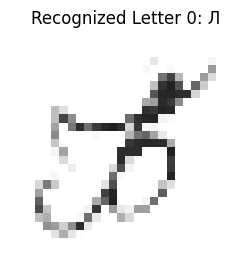

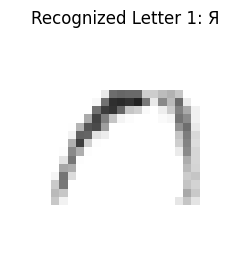

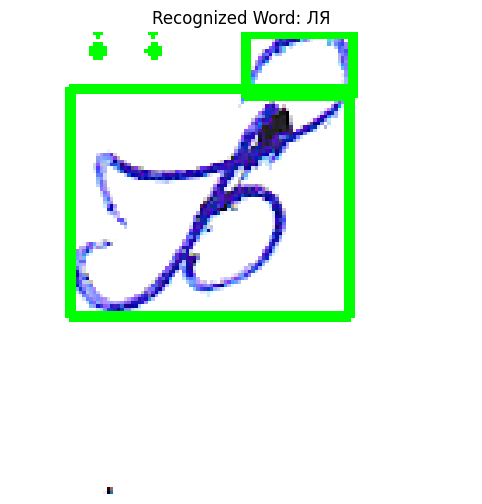

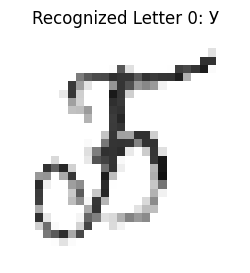

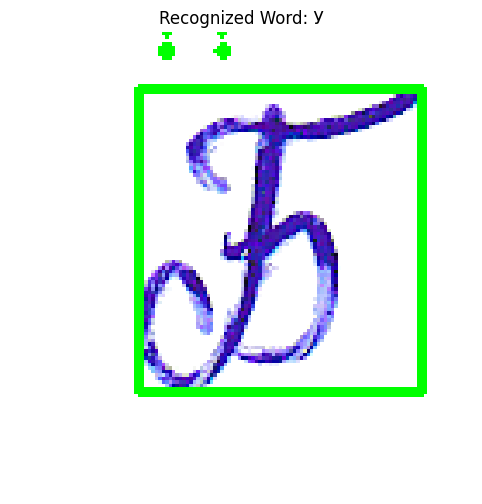

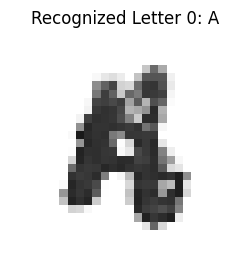

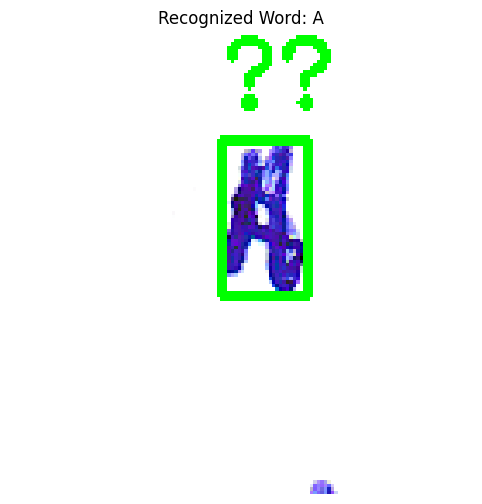

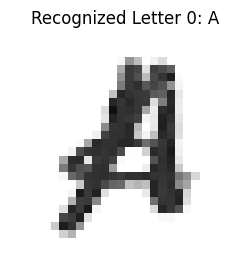

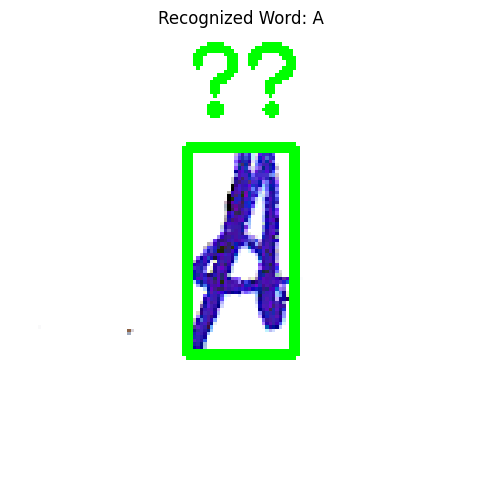

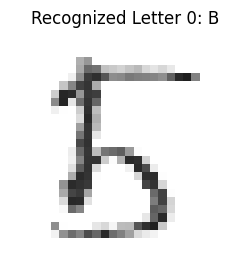

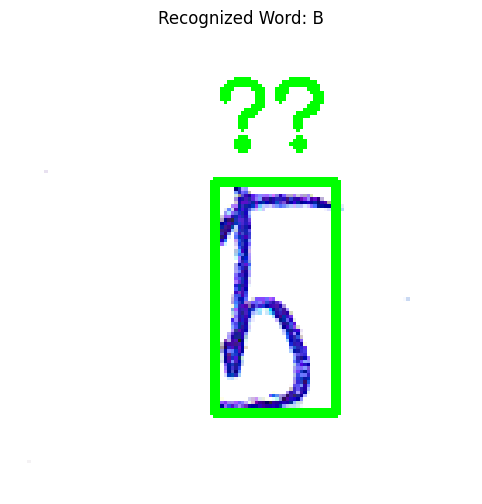

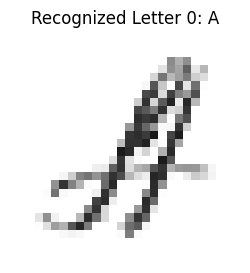

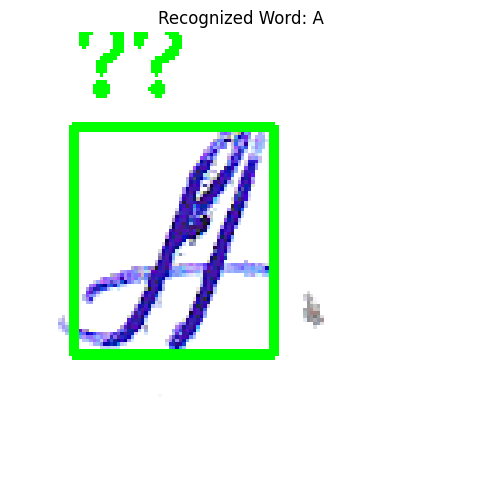

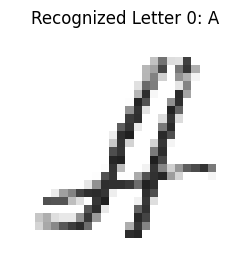

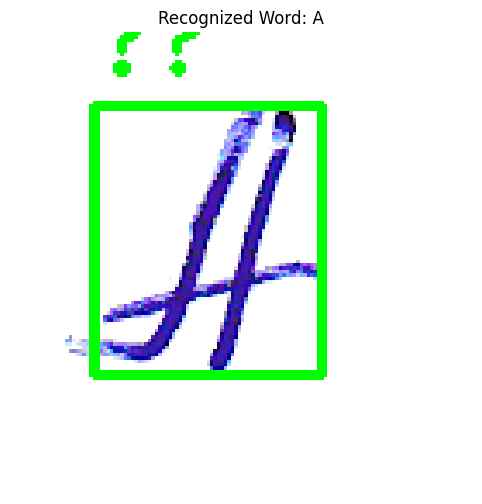

Image Name: img017_-1_15, Recognized Word: ЛЯ, Accuracy: 0.00%
Image Name: img017_-1_10, Recognized Word: У, Accuracy: 0.00%
Image Name: img023_-1_6, Recognized Word: А, Accuracy: 0.00%
Image Name: img023_-1_5, Recognized Word: А, Accuracy: 0.00%
Image Name: img017_-1_20, Recognized Word: В, Accuracy: 0.00%
Image Name: img023_-1_4, Recognized Word: А, Accuracy: 0.00%
Image Name: img023_-1_3, Recognized Word: А, Accuracy: 0.00%


In [ ]:
# Example usage
folder_path = '../data/test/'  # Replace with your folder containing images
recognition = FolderWordRecognition(folder_path)
recognition.process_images()
